In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from natsort import natsorted

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'torwic':
    os.chdir('../..')
print(os.getcwd())

/mnt/C45ADD865ADD7620/i3d-rrc/ic-topo-nav/mickst3r


In [2]:
from scipy.spatial import KDTree
dataset_root = Path("./data/TorWIC-SLAM")

image_type = "image_right"
scene_day = "Jun15"
ref_scene_run = "Hallway_Full_CCW"
query_scene_run = "Aisle_CCW_Run_1"

ref_traj_file = Path("./data/gt_image_right_poses_tum_ref.txt")
ref_gt_poses = ref_traj_file.read_text().splitlines()
ref_gt_poses_array = np.array([list(map(float, pose.split())) for pose in ref_gt_poses])
ref_kd_tree = KDTree(ref_gt_poses_array[:, 1:3])

ref_image_folder = dataset_root / scene_day / ref_scene_run / image_type
ref_image_files = natsorted(list(ref_image_folder.glob("*.png")))

query_traj_file = Path("./data/gt_image_right_poses_tum_query_down.txt")
query_gt_poses = query_traj_file.read_text().splitlines()
query_gt_poses_array = np.array([list(map(float, pose.split())) for pose in query_gt_poses])

query_image_folder = dataset_root / scene_day / query_scene_run / image_type
query_image_files = natsorted(list(query_image_folder.glob("*.png")))
query_image_files = query_image_files[::10]

assert len(ref_image_files) == len(ref_gt_poses_array)
assert len(query_image_files) == len(query_gt_poses_array)

In [3]:
# QUERY_IMAGE_IDX = 0

# # query the nearest neighbor in the reference trajectory
# query_pose = query_gt_poses_array[QUERY_IMAGE_IDX]
# _, ref_idx = ref_kd_tree.query(query_pose[1:3])
# ref_pose = ref_gt_poses_array[ref_idx]

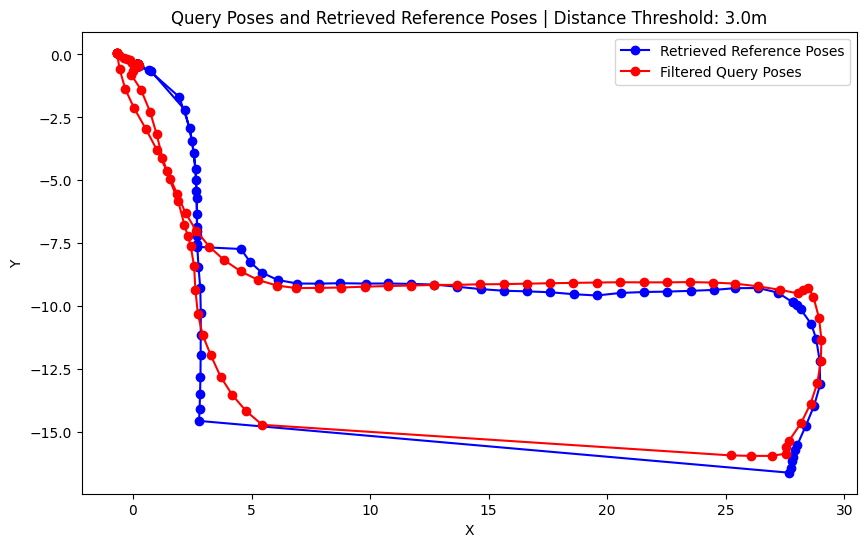

In [4]:
# Loop over all query images and retrieve the nearest reference pose
DIST_THRESHOLD = 3.0

retrieved_ref_poses = []
filtered_query_poses = []
for query_pose in query_gt_poses_array:
    distance, ref_idx = ref_kd_tree.query(query_pose[1:3])  # Using tx, ty, tz for querying
    if distance < DIST_THRESHOLD:  # Skip if the nearest pose is 3m or further
        ref_pose = ref_gt_poses_array[ref_idx]
        retrieved_ref_poses.append(ref_pose)
        filtered_query_poses.append(query_pose)

# Convert lists to numpy arrays for easier plotting
filtered_query_positions = np.array(filtered_query_poses)[:, 1:3]  # Assuming the poses are in columns 1 to 3
retrieved_ref_positions = np.array(retrieved_ref_poses)[:, 1:3]  # Assuming the poses are in columns 1 to 3

# Plot the query poses and retrieved reference poses
plt.figure(figsize=(10, 6))

plt.plot(retrieved_ref_positions[:, 0], retrieved_ref_positions[:, 1], 'bo-', label='Retrieved Reference Poses')
plt.plot(filtered_query_positions[:, 0], filtered_query_positions[:, 1], 'ro-', label='Filtered Query Poses')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Query Poses and Retrieved Reference Poses | Distance Threshold: {DIST_THRESHOLD}m') 
plt.legend()

plt.show()

In [5]:
from mast3r_src.model import AsymmetricMASt3R

from dust3r_src.dust3r.inference import inference
from dust3r_src.dust3r.utils.image import load_images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_name = "./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

Using device: cuda
... loading model from ./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


>> Loading a list of 2 images
 - adding data/TorWIC-SLAM/Jun15/Hallway_Full_CCW/image_right/000072.png with resolution 1280x720 --> 512x288
 - adding data/TorWIC-SLAM/Jun15/Aisle_CCW_Run_1/image_right/000000.png with resolution 1280x720 --> 512x288
 (Found 2 images)
(288, 512, 3)
(288, 512, 3)


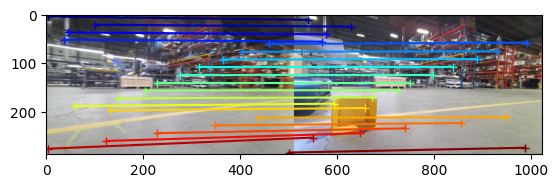

In [6]:
# pick the first image for testing
image_q_path = query_image_files[int(filtered_query_poses[0][0])]
image_r_path = ref_image_files[int(retrieved_ref_poses[0][0])]

from mast3r_src.fast_nn import fast_reciprocal_NNs

device = 'cuda'

images = load_images([str(image_r_path), str(image_q_path)], size=512)
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                device=device, dist='dot', block_size=2**13)

# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

# visualize a few matches
n_viz = 20
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    print(viz_imgs[i].shape)

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
plt.figure()
plt.imshow(img)
cmap = plt.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    plt.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
plt.show(block=True)